# Code to automate preprocessing of openbeacon id.

Requires having a file combining all chip data in long format

1) Calculate eigenvector centrality to find most connected chips
2) walk graph by iteratively estimating a robust regression to calculate timing offset of remote chip until all chips have been aligned to common time.
3) drop outlier datapoints


In [182]:
import os
import glob
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.stats import regress
import networkx as nx

base_dir = '/Users/lukechang/Dropbox/MIND_OpenBeacon/'

In [89]:
data = pd.read_csv(os.path.join(base_dir, 'Data','mind_openbeacon_long.csv'), index_col=0)


/Users/lukechang/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [90]:
data.head()

,tag_me,tag_them,time_local_s,time_remote_s,rssi,angle,group,rssi_recoded
0,0x4E28C018,0x3E508E4C,620,11455,-82,-18,1,7
1,0x4E28C018,0x3E508E4C,635,11471,-87,0,1,2
2,0x4E28C018,0x3E508E4C,637,11472,-86,1,1,3
3,0x4E28C018,0x3E508E4C,638,11474,-85,2,1,4
4,0x4E28C018,0x3E508E4C,639,11475,-85,-1,1,4


In [93]:
print(len(data['tag_me'].unique()))
print(len(data['tag_them'].unique()))

30
36


## Identify missing chips

In [141]:
missing_tags = set(data['tag_them']) - set(data['tag_me'])

## Run Regression to estimate slope and pairwise temporoal

Notes: 
- Only looking at Group 1 for now.

In [200]:
tag_me_id = data['tag_me'].unique()
missing_tags = set(data['tag_them']) - set(data['tag_me'])

tag_intercept = np.ones((len(tag_me_id),len(tag_me_id)))*np.nan
tag_slope = tag_intercept.copy()

for i, tag_1 in enumerate(tag_me_id):
    tag_1_dat = data.loc[(data['tag_me'] == tag_1) & (data['group'] == 1)]
    tag_2_id = [x for x in tag_1_dat['tag_them'].unique() if x not in missing_tags]
    for j, tag_2 in enumerate(tag_2_id):
        tag_2_dat = tag_1_dat.loc[data['tag_them'] == tag_2]
        dm = np.vstack([np.ones(len(tag_2_dat['time_local_s'])), tag_2_dat['time_local_s']]).T
        b, t, p, df, res = regress(dm, tag_2_dat['time_remote_s'], mode='robust')
        tag_intercept[i,j], tag_slope[i,j] = b
        

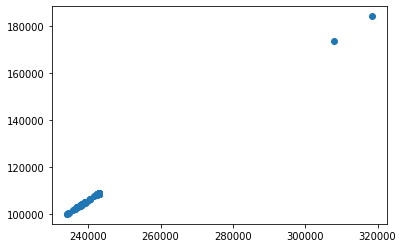

In [229]:
plt.scatter(tag_2_dat['time_local_s'], tag_2_dat['time_remote_s'])

# Preprocessing functions

In [252]:
def tag_centrality(data):
    '''Calculate tag eigenvector centrality from the long format data'''
    tag_me_id = data['tag_me'].unique()
    missing_tags = set(data['tag_them']) - set(data['tag_me'])
    tag_adjacency = pd.DataFrame(np.zeros((len(tag_me_id),len(tag_me_id))), index=tag_me_id, columns=tag_me_id)
    tag_duration = {}
    for i,tag_1 in enumerate(tag_me_id):
        tag_1_dat = data.loc[(data['tag_me'] == tag_1) & (data['group'] == 1)]
        tag_duration[tag_1] = tag_1_dat['time_local_s'].max() - tag_1_dat['time_local_s'].min()
        tag_2_id = [x for x in tag_1_dat['tag_them'].unique() if x not in missing_tags]
        for j,tag_2 in enumerate(tag_2_id):
            tag_adjacency.loc[tag_1, tag_2] = 1
    g = nx.from_pandas_adjacency(tag_adjacency)
    return nx.eigenvector_centrality(g)

def find_most_connected_tag(tag_centrality):
    return max(tag_centrality, key=tag_centrality.get)

def find_outliers(residuals, outlier_threshold = 3):
    '''This function identifies any values that are greater than a threshold 
        of the residual standard error of the estimate.
    '''
    return np.abs(residuals) > outlier_threshold*residuals.std()

 

In [265]:
eig_centrality = tag_centrality(data)
sorted_ids_centrality = [x[0] for x in sorted(eig_centrality.items(), key=lambda kv: kv[1], reverse=True)]

In [274]:
group = 1
missing_tags = set(data['tag_them']) - set(data['tag_me'])

tag_intercept = np.ones((len(tag_me_id),len(tag_me_id)))*np.nan
tag_slope = tag_intercept.copy()

temporally_aligned = {}
bad_alignment = {}
alignment = {}
new_data = pd.DataFrame()
for tag_1 in sorted_ids_centrality:
    tag_1_dat = data.loc[(data['tag_me'] == tag_1) & (data['group'] == group)]
    tag_2_id = [x for x in tag_1_dat['tag_them'].unique() if x not in missing_tags]
    tag_2_alignment = {}
    for tag_2 in tag_2_id:
        tag_2_dat = tag_1_dat.loc[data['tag_them'] == tag_2]
        design_matrix = np.vstack([np.ones(len(tag_2_dat['time_local_s'])), tag_2_dat['time_local_s']]).T
        b, t, p, df, res = regress(design_matrix, tag_2_dat['time_remote_s'], mode='robust')
        tag_2_alignment[tag_2] = {'remote_offset':b[0], 'remote_drift':b[1]}
        if np.isclose(b[1], 1):
            tag_2_dat['time_remote_adjusted_time'] = tag_2_dat['time_remote_s'] + b[0]
            tag_2_dat['time_remote_outlier'] = find_outliers(res)
            new_data = new_data.append(tag_2_dat)
            temporally_aligned[tag_1] = tag_2
        else:
            bad_alignment[tag_1] = tag_2
    alignment[tag_1] = tag_2_alignment


/Users/lukechang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/lukechang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyboardInterrupt: 

In [275]:
alignment

{'0x126EBE99': {'0x57BE2613': {'remote_offset': -4814.891709029076,
   'remote_drift': 0.9999750084711221}},
 '0x4971A32A': {'0x126EBE99': {'remote_offset': 95587.96956204402,
   'remote_drift': -0.09820612264167707},
  '0x66092520': {'remote_offset': -868.9882524699011,
   'remote_drift': 0.9999940313728438},
  '0x2FC03DD0': {'remote_offset': 16576.425792763177,
   'remote_drift': 0.04123472700344234},
  '0x392C8E4F': {'remote_offset': -1206.2090935989252,
   'remote_drift': 0.9999947614946578},
  '0x6E0E454C': {'remote_offset': 33291.57966146343,
   'remote_drift': 1.0000132260915897},
  '0x04958E5A': {'remote_offset': -1168.601032888831,
   'remote_drift': 1.0000030805638485},
  '0x33B9F6B6': {'remote_offset': 45525.53782924618,
   'remote_drift': 0.9999950166005724},
  '0x34AB57A6': {'remote_offset': 100769.8697477814,
   'remote_drift': 0.0762835725160334},
  '0x4095A5C2': {'remote_offset': -3890.4594138808475,
   'remote_drift': 0.9999962395207121},
  '0x50126E5B': {'remote_offse

In [270]:
bad_alignment

{'0x126EBE99': '0x57BE2613',
 '0x4971A32A': '0x08007C57',
 '0x784692B5': '0x4266810A',
 '0x08007C57': '0x138A8579'}

In [222]:
pd.DataFrame(npa.isclose(tag_slope, 1), index=tag_me_id, columns=tag_2_id)

ValueError: Shape of passed values is (30, 30), indices imply (30, 27)

In [221]:
g = nx.from_numpy_array()
pos = pos = nx.spring_layout(g) # Another way of specifiying a layout for nodes.
nx.draw(g,with_labels=False,node_size=200,font_size=20,alpha=.9,width=2,node_color='skyblue',edge_color='navy',edgecolors='navy')


ValueError: Shape of passed values is (30, 30), indices imply (30, 27)

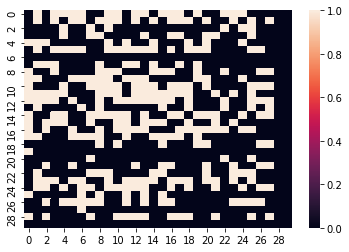

In [213]:
sns.heatmap(np.isclose(tag_slope, 1))

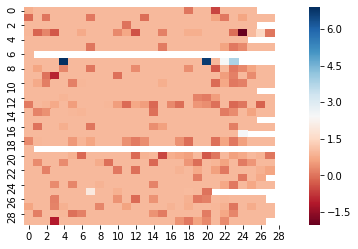

In [156]:
sns.heatmap(tag_slope, cmap='RdBu')

(array([159.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([0.00621119, 0.05846067, 0.11071015, 0.16295963, 0.21520911,
        0.26745859, 0.31970807, 0.37195755, 0.42420703, 0.47645651,
        0.52870599]),
 <a list of 10 Patch objects>)

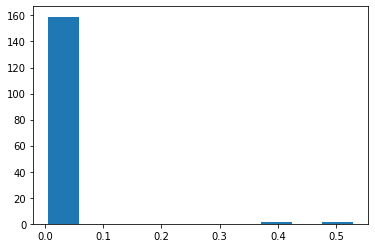

In [161]:
plt.hist(np.diagonal(dm.dot(np.linalg.pinv(dm))))

# Calculate eigenvector centrality of each tag to identify regression order

'0x126EBE99'

(array([ 7.,  1.,  1.,  1.,  0.,  0.,  3.,  0., 15.,  2.]),
 array([  2633. ,  34379.2,  66125.4,  97871.6, 129617.8, 161364. ,
        193110.2, 224856.4, 256602.6, 288348.8, 320095. ]),
 <a list of 10 Patch objects>)

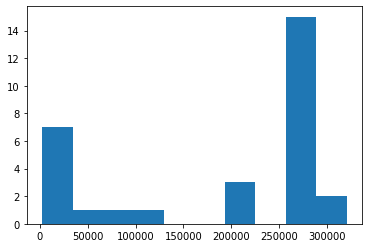

In [196]:
plt.hist(tag_duration.values())

In [166]:
tag_1_dat['time_local_s'].max() - tag_1_dat['time_local_s'].min()

280673

In [186]:
g?

In [183]:
nx.from_pandas_dataframe(tag_adjacency)

AttributeError: module 'networkx' has no attribute 'from_pandas_dataframe'

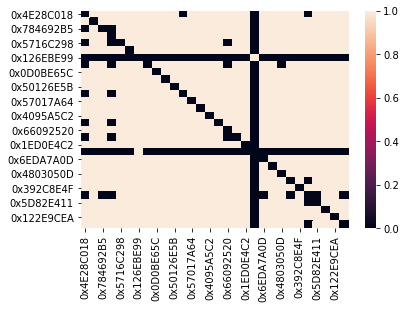

In [180]:
sns.heatmap(tag_adjacency)


/Users/lukechang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  after removing the cwd from sys.path.


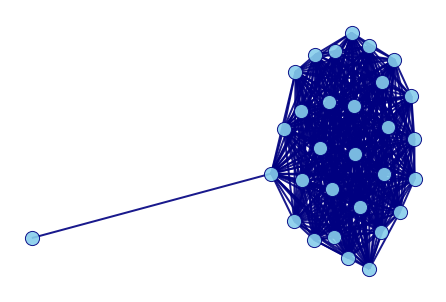

In [192]:
pos = pos = nx.fruchterman_reingold_layout(g) # Another way of specifiying a layout for nodes.
# pos = pos = nx.spring_layout(g) # Another way of specifiying a layout for nodes.
nx.draw(g,with_labels=False,node_size=200,font_size=20,alpha=.9,width=2,node_color='skyblue',edge_color='navy',edgecolors='navy')
plt.tight_layout()